In [8]:
import pandas as pd
import numpy as np
from math import floor
import skimage
from skimage.measure import shannon_entropy
from skimage.feature import greycoprops
from skimage.feature import greycomatrix
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sn

def vector_mappings(X, k):
    img_data = []
    N, M = X[0].shape

    n_starts = list(map( 
        lambda lst: lst[0], 
        np.array_split( np.arange(N) ,k) 
        ))
    n_ends = list(map( 
        lambda lst: lst[-1], 
        np.array_split( np.arange(N) ,k) 
        ))
    n_bounds = list( zip(n_starts, n_ends) )

    m_starts = list(map( 
        lambda lst: lst[0], 
        np.array_split( np.arange(M) ,k) 
        ))
    m_ends = list(map( 
        lambda lst: lst[-1], 
        np.array_split( np.arange(M) ,k) 
        ))
    m_bounds = list( zip(m_starts, m_ends) )

    X = skimage.img_as_ubyte(X)
    for grayImg in X:
        for n0, n1 in n_bounds:
            for m0, m1 in m_bounds:
                img = grayImg[n0:n1, m0:m1]

                gm = GaussianMixture()
                gm.fit( img.reshape((img.size, 1)) )
                color_mean = gm.means_[0][0]

                g = greycomatrix(img, [1], [0])
                entropy = shannon_entropy(img)
                homogeneity = greycoprops(g, 'homogeneity')[0][0]
                energy = greycoprops(g, 'energy')[0][0]
                contrast = greycoprops(g, 'contrast')[0][0]

                img_data.append( [color_mean, entropy, homogeneity, energy, contrast] )
    
    img_data = np.array(img_data)
    n = len(n_starts)
    m = len(m_starts)
    total_images = X.shape[0]
    return img_data, n, m, total_images

class emotional_bayes():
    def __init__(self, X_train, y_train, X_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        return

    def vector_mappings_train(self, k):
        self.k = k
        self.train_img_data, self.train_n, self.train_m, self.train_total_images = vector_mappings(self.X_train, self.k)
        self.test_img_data, self.test_n, self.test_m, self.test_total_images = vector_mappings(self.X_test, self.k)
        return

    def k_means_clustering_train(self, n_clusters):
        self.n_clusters = n_clusters

        # put pc code here if you want

        self.kmeans_mdl = KMeans(n_clusters=n_clusters, random_state=0)
        self.kmeans_mdl.fit(self.train_img_data)

        # map k-means results to block
        self.post_X_train = self.kmeans_mdl.labels_.reshape( 
            self.train_total_images, 
            self.train_n*self.train_m 
        )
        self.df_train = pd.DataFrame(
            self.post_X_train, 
            index = ["Image %d" % i for i in range(1, self.train_total_images+1)],
            columns = ["Block %d" % i for i in range(1, self.train_n*self.train_m+1)]
            )
        return
    
    def fit(self):
        self.nb_mdl = MultinomialNB()
        self.nb_mdl.fit( self.post_X_train, self.y_train )
        return

    def predict(self):
        post_X_test = self.kmeans_mdl.predict( self.test_img_data ).reshape( 
            self.test_total_images,
            self.test_n * self.test_m 
        )
        pred = self.nb_mdl.predict( post_X_test )
        return pred

In [4]:
# Mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Get data
X_train = np.load('/content/drive/MyDrive/CPE-695 Final Project/Data/cropped_train_data.npy')
X_test = np.load('/content/drive/MyDrive/CPE-695 Final Project/Data/cropped_test_data.npy')
y_train = np.load('/content/drive/MyDrive/CPE-695 Final Project/Data/cropped_train_labels_encoded.npy')
y_test = np.load('/content/drive/MyDrive/CPE-695 Final Project/Data/cropped_test_labels_encoded.npy')

In [6]:
# Confirm shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28709, 29, 48)
(7178, 29, 48)
(28709,)
(7178,)


In [9]:
grid_sizes = [2, 3, 4, 5, 8, 10]
cluster_sizes = list(range(2, 11))
accuracy_results = np.zeros( (len(grid_sizes), len(cluster_sizes)) )
precision_results = np.zeros( (len(grid_sizes), len(cluster_sizes)) )
recall_results = np.zeros( (len(grid_sizes), len(cluster_sizes)) )
f1_results = np.zeros( (len(grid_sizes), len(cluster_sizes)) )

mdl = emotional_bayes(X_train, y_train, X_test)
for i, grid_size in enumerate(grid_sizes):
  mdl.vector_mappings_train(k=grid_size)
  for j, cluster_size in enumerate(cluster_sizes):
    print( "Starting:", (grid_size, cluster_size) )
    mdl.k_means_clustering_train(n_clusters=cluster_size) # play around with ecludian distance vs cosine similarty
    mdl.fit()
    pred = mdl.predict()

    accuracy_results[i, j] = accuracy_score(y_test, pred)
    precision_results[i, j] = precision_score(y_test, pred, average='weighted')
    recall_results[i, j] = recall_score(y_test, pred, average='weighted')
    f1_results[i, j] = f1_score(y_test, pred, average='weighted')

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


Starting: (2, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (2, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (2, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (2, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (2, 6)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (2, 7)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (2, 8)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (2, 9)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (2, 10)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


Starting: (3, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (3, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (3, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (3, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (3, 6)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (3, 7)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (3, 8)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (3, 9)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (3, 10)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


Starting: (4, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (4, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (4, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (4, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (4, 6)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (4, 7)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (4, 8)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (4, 9)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (4, 10)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


Starting: (5, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (5, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (5, 4)
Starting: (5, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (5, 6)
Starting: (5, 7)
Starting: (5, 8)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (5, 9)
Starting: (5, 10)


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


Starting: (8, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (8, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (8, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (8, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Starting: (8, 6)
Starting: (8, 7)
Starting: (8, 8)
Starting: (8, 9)
Starting: (8, 10)


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return convert(image, np.uint8, force_copy)


Starting: (10, 2)
Starting: (10, 3)
Starting: (10, 4)
Starting: (10, 5)
Starting: (10, 6)
Starting: (10, 7)
Starting: (10, 8)
Starting: (10, 9)
Starting: (10, 10)


In [ ]:
# accuracy_results
np.array([[0.24714405, 0.24714405, 0.24714405, 0.24714405, 0.24714405, 0.24714405, 0.24463639, 0.24602953, 0.24714405],
          [0.24714405, 0.24714405, 0.24714405, 0.25020897, 0.24979103, 0.25062692, 0.24895514, 0.23349122, 0.24491502],
          [0.25968236, 0.25940373, 0.25188075, 0.24784062, 0.23962106, 0.24630816, 0.23446643, 0.23446643, 0.23850655],
          [0.26567289, 0.26971301, 0.277236  , 0.2581499 , 0.24742268, 0.26232934, 0.25006966, 0.22290332, 0.2141265 ],
          [0.24714405, 0.25689607, 0.25285595, 0.24881583, 0.25982168, 0.22401783, 0.24212873, 0.24770131, 0.24839788],
          [0.26678741, 0.25564224, 0.25104486, 0.23725272, 0.22680412, 0.21008638, 0.21384787, 0.23279465, 0.22318194]])

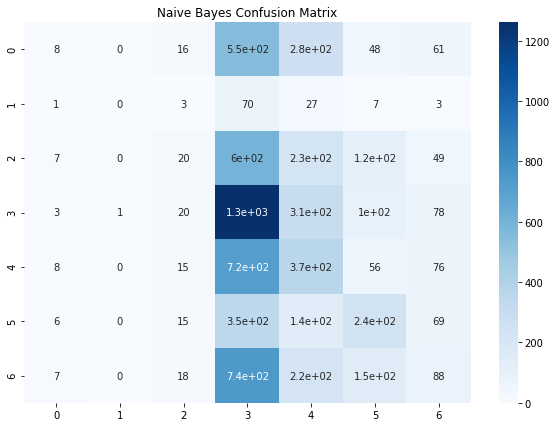

In [11]:
mdl = emotional_bayes(X_train, y_train, X_test)
mdl.vector_mappings_train(k=5)
mdl.k_means_clustering_train(n_clusters=4) # play around with ecludian distance vs cosine similarty
mdl.fit()
pred = mdl.predict()

cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(
    cm, 
    index = list(range(0,7)),
    columns = list(range(0,7))
  )
plt.figure(figsize = (10,7))
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel=('True')
plt.ylabel=('Predicted')
sn.heatmap(df_cm, annot=True, cmap='Blues')

In [12]:
accuracy_score(y_test, pred)

0.27723599888548345

In [13]:
train_pred = mdl.nb_mdl.predict( mdl.post_X_train )
accuracy_score(y_train, train_pred)

0.2761155038489672